In [1]:
from Functions import *


In [2]:
''' loop parameters '''
alphaAsym = np.deg2rad(29.5)
f1 = 10.    # crystal-mirror distance
f2 = 10.    # mirror focal distance

if_plot = 1
if_loop = 1


In [3]:
''' Beam parameters '''
N = 1024			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 10000		# total simulation time window [fs]

''' OE parameters '''
# hkl = [6,6,0]
hkl = [4,4,0]
#hkl = [3,3,3] 

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
	'photonEnergy': E0,
	'N': N,
	'sigma_x': 23e-6,
	'sigma_y': 23e-6,
	'rangeFactor': 5,
	'scaleFactor': 10,
	'z_source': 630
}

In [4]:
''' IO '''
path = '../{} eV/'.format(E0)
make_dir(path)

fig_path = path+'test_run'
make_dir(fig_path)

hkl_ = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'pulse_duration_{}_{}keV'.format(
    hkl_, round(beam_params['photonEnergy']/1000.,4))


path exists
path exists


In [5]:
def define_devices(
    f1, f2, slit_width = 1e-3, hkl = [4,4,0], alphaAsym = 0., E0=18e3, f0 = 290., d23=7.):

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=870, FOV=5e-3, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)
    # viewing point - after C1
    im_after_C1 = optics.PPM('im_after_C1', z=crystal1.z+.01, FOV=5e-3, N=256)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2,pol='s', delta=0e-6)
    # viewing point - after C2
    im_after_C2 = optics.PPM('im_after_C2', z=crystal2.z+.01, FOV=5e-3, N=256)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    # viewing point - before MIR1
    im_before_MIR1 = optics.PPM('im_before_MIR1', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

    # elliptical mirror with ~10 meter focal length
    mir1 = optics.CurvedMirror('mir1', z=crystal2.z+f1, p=1e5, q=f2, length=1.0, width=5e-3, alpha=3.6e-3, orientation=2)

    # viewing point - after MIR1
    im_after_MIR1 = optics.PPM('im_after_MIR1', z=mir1.z+.1, FOV=5e-3, N=256)

    # slit at focus
    slit = optics.Slit('slit', z=mir1.z+f2, x_width=slit_width, y_width=2e-3)

    # viewing point at focus
    im_focus = optics.PPM('im_focus', z=mir1.z+f2 + 1e-3, FOV=1e-3, N=256)

    # viewing point - before MIR2
    im_before_MIR2 = optics.PPM('im_before_MIR2', z=mir1.z+2*f2 -.1, FOV=2e-3, N=256)
    # elliptical mirror with ~10 meter focal length, for collimation
    mir2 = optics.CurvedMirror('mir2', z=mir1.z+2*f2, p=f2, q=1e5, length=1.0, width=5e-3, alpha=3.6e-3, orientation=0)
    # viewing point - after MIR2
    im_after_MIR2 = optics.PPM('im_after_MIR2', z=mir1.z+2*f2 +.1, FOV=2e-3, N=256)
    
    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=mir2.z+d23, E0=E0,alphaAsym=0, orientation=2,
                             asym_type='emergence',pol='s')
    # viewing point - after C3
    im_after_C3 = optics.PPM('im_after_C3', z=crystal3.z+.01, FOV=5e-3, N=256)

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=mir2.z+d23 + (f1-d23)*np.cos(crystal1.beta0*2), E0=E0,alphaAsym=-alphaAsym, 
                              asym_type='emergence', orientation=0,pol='s')

    # viewing point - output
    im_out = optics.PPM('im_out', z=crystal4.z+.1, FOV=5e-3, N=256)

    # list of devices to propagate through
    devices = [crl0,im_input, crystal1,im_after_C1, crystal2,im_after_C2, im_before_MIR1,mir1,im_after_MIR1, slit,im_focus,
               im_before_MIR2,mir2,im_after_MIR2, crystal3,im_after_C3, crystal4,im_out]

    return devices

In [6]:
''' Define beamline '''
try: alphaAsym
except:
    crystal_temp = optics.Crystal('crystal', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                                  alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    alphaAsym = crystal_temp.alpha - np.deg2rad(5)      # calculate miscut angle (5 degree grazing incidence)

    if alphaAsym <= 0:
        print('\n***\n***\n*** Bragg angle smaller than grazing angle')

devices = define_devices(f1,f2,slit_width = 2000e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)

b 1.00
b 4.10
crystal 2 incidence angle: 72.43 degrees
crystal 2 exit angle: 13.43 degrees
b 1.00
b 0.24


In [7]:
%%capture capt
''' propagate '''
mono_beamline = beamline.Beamline(devices)

tstart = time.time()
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

screen_names = ['im_after_C1','im_after_C2','im_before_MIR1','im_after_MIR1','im_focus','im_before_MIR2','im_after_MIR2','im_after_C3','im_out']

pulse.propagate(beamline=mono_beamline, screen_names=screen_names)
tfin = time.time()

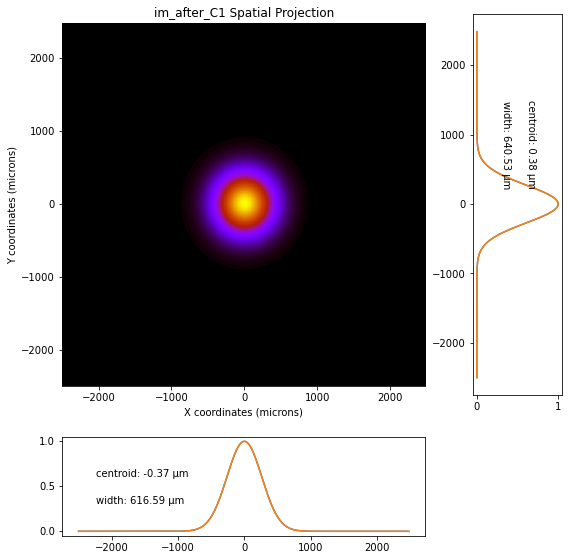

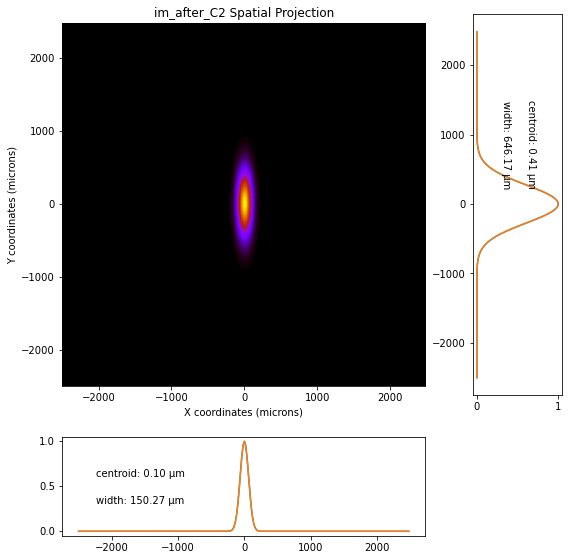

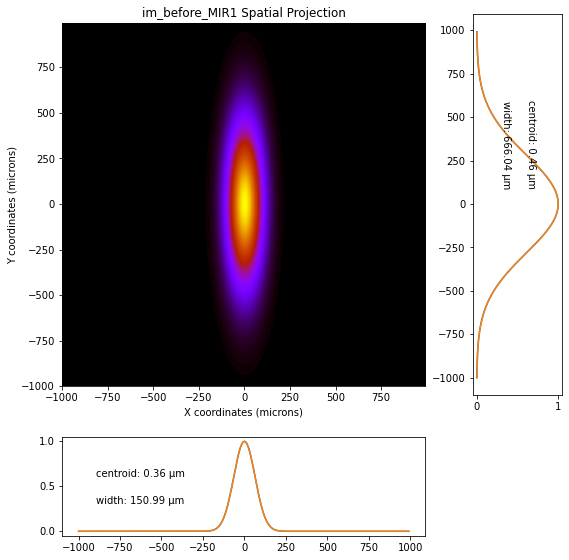

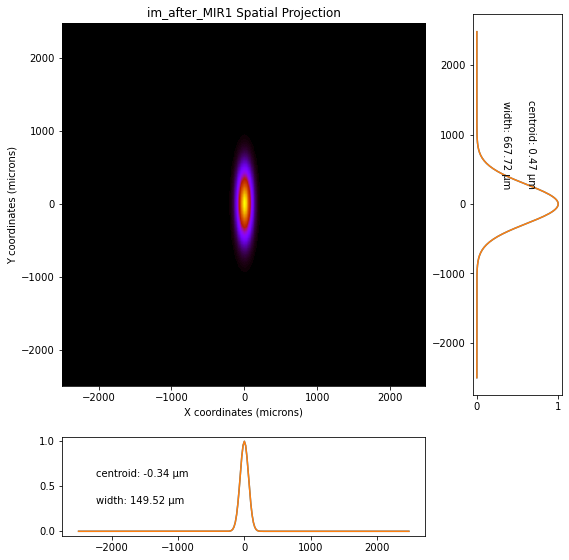

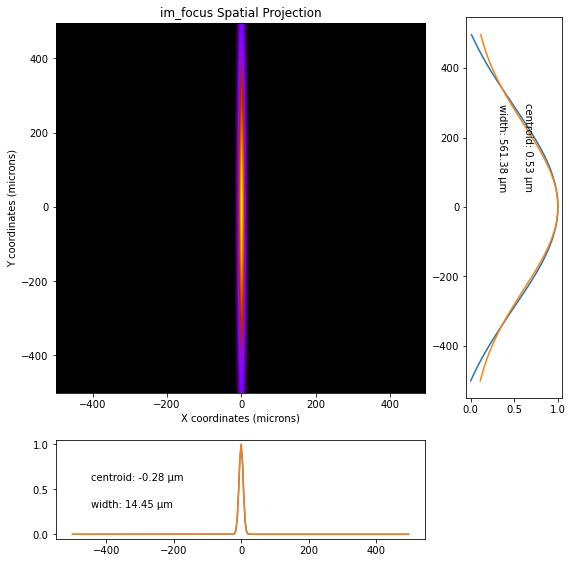

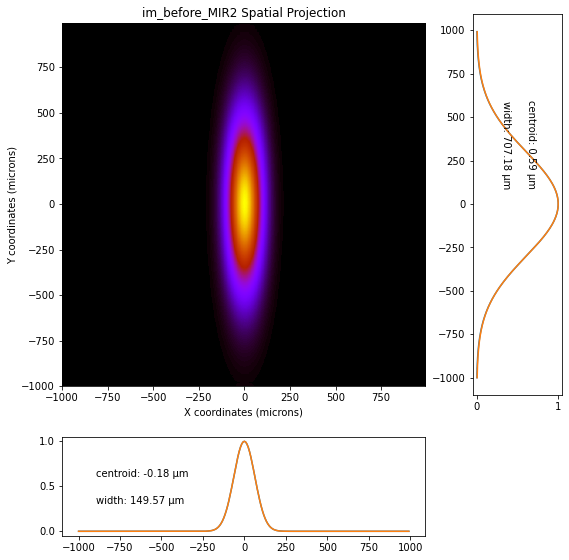

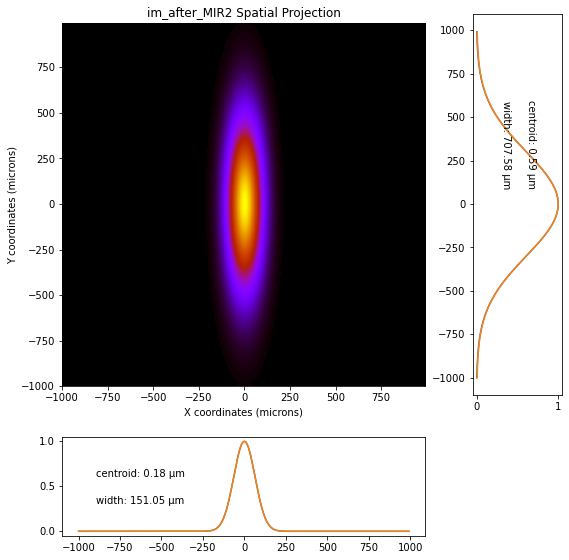

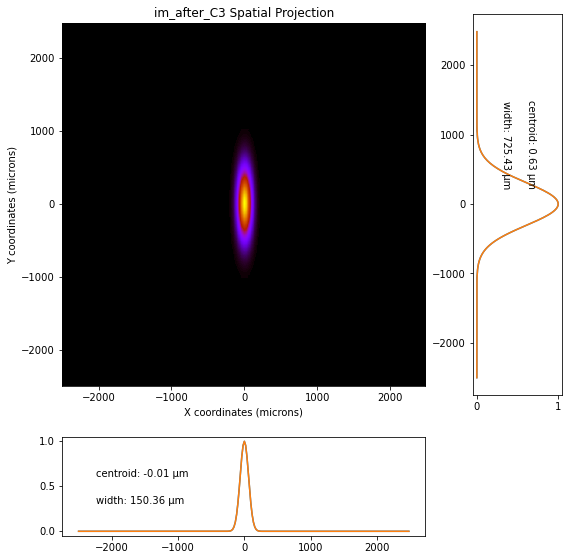

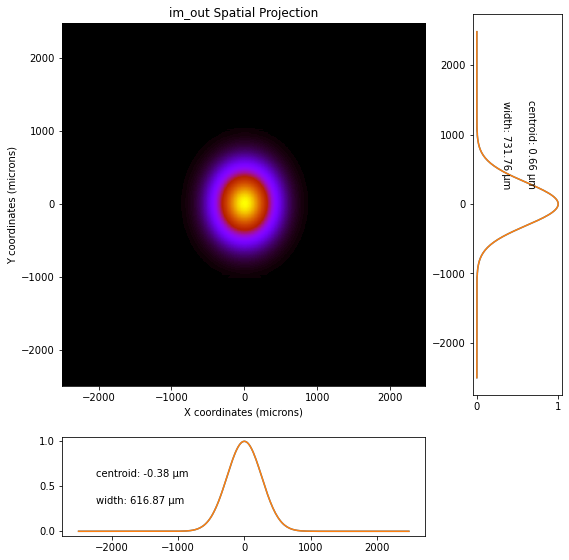

In [8]:
''' projection '''
for screen_name in pulse.screens:
    pulse.imshow_projection(screen_name)


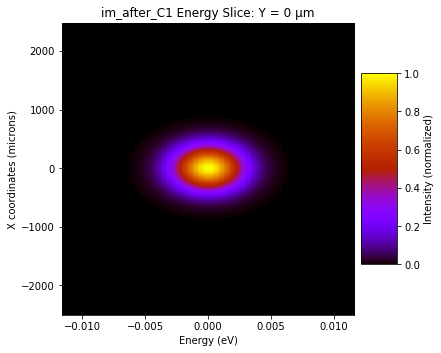

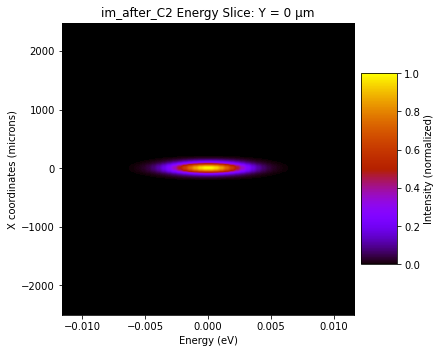

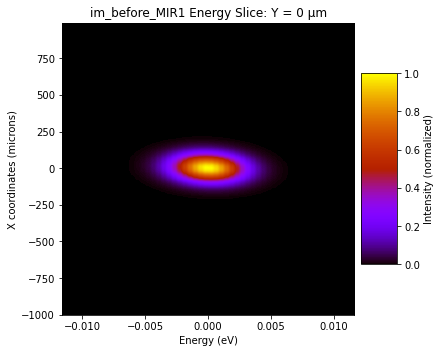

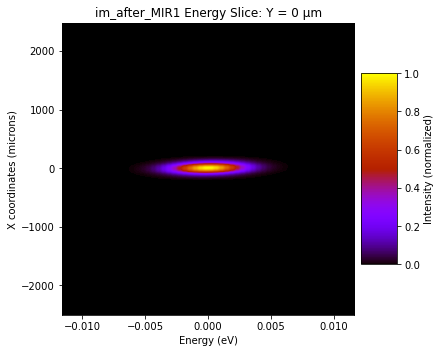

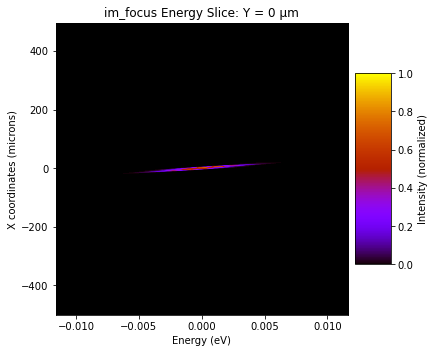

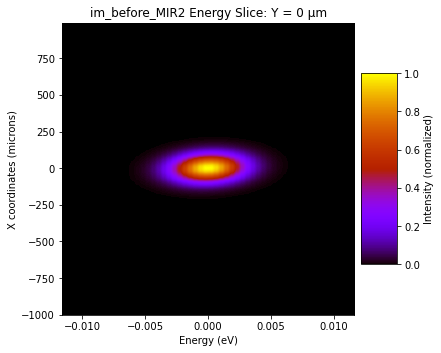

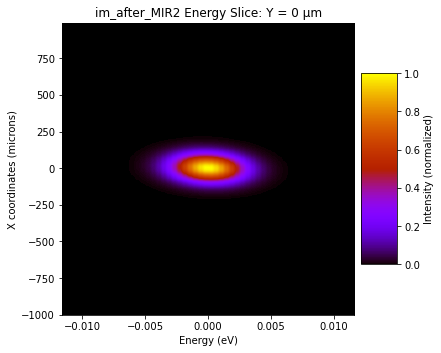

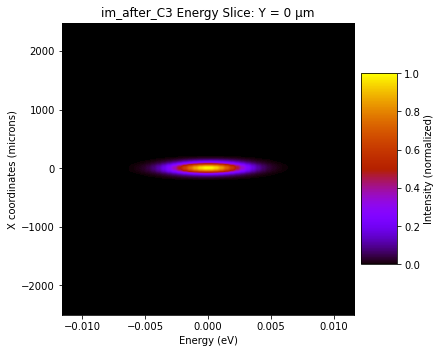

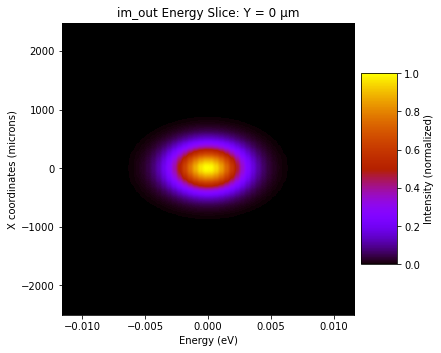

In [9]:
''' energy slices '''
for screen_name in pulse.screens:
    try:
        pulse.imshow_energy_slice(screen_name)
    except:
        print(screen_name + ' failed')


total 12.74s, per slice 227.47ms


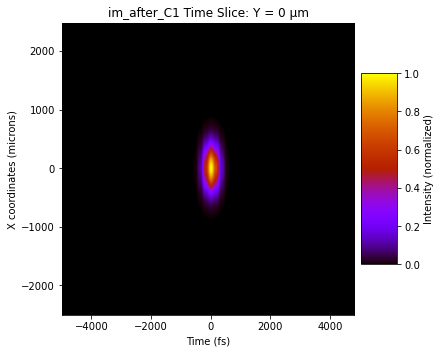

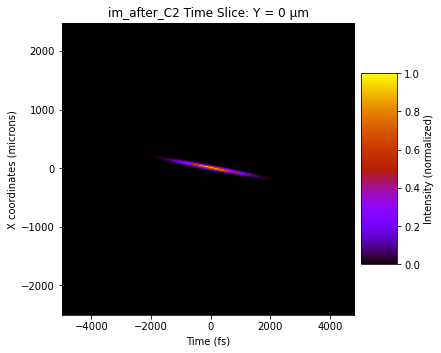

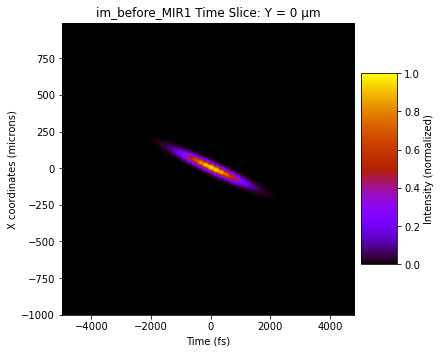

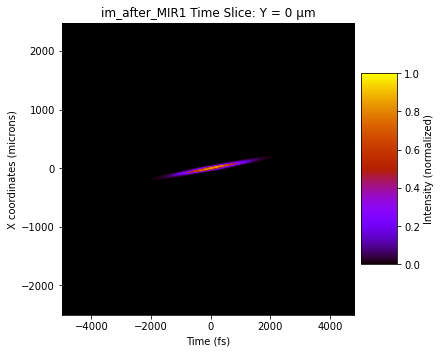

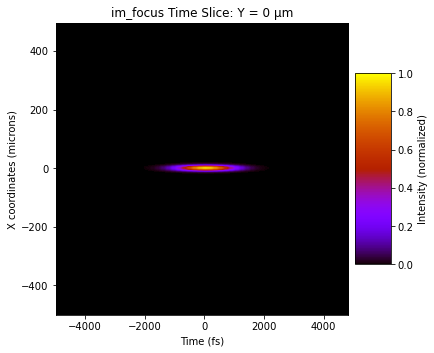

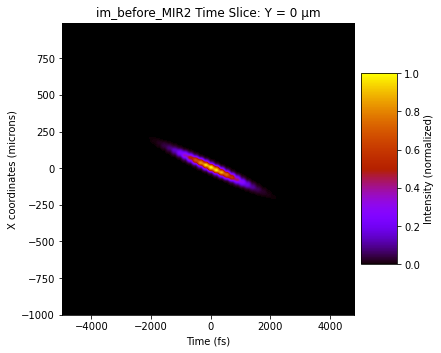

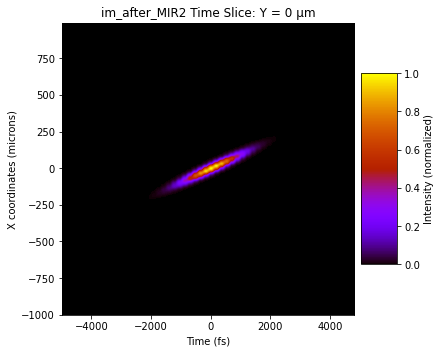

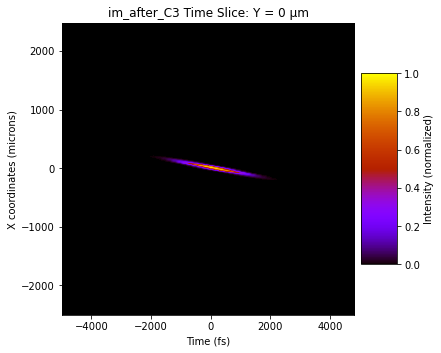

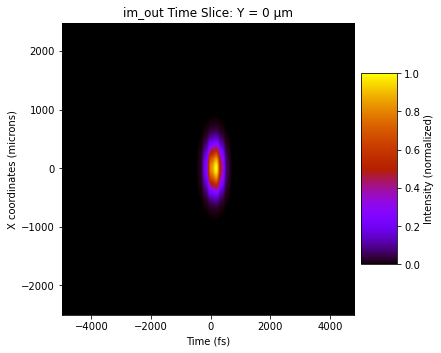

In [10]:
''' plot time slices '''
print('total {}s, per slice {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))

shift = 0
for screen_name in pulse.screens:
    pulse.imshow_time_slice(screen_name, shift=shift)
